<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>


A priori knowledge:

41.340 rows, each corresponding to one player. The variables are:

* platform: an integer representing the player's' platform, e.g. iOS
* country: an integer representing the player's' country, e.g. Portugal
* sessions_length: the number of seconds the player spent in the game
* sessions: the number of times the player opened the game
* retained_days: the difference, in days, between the last and first calendar dates the player played
* login_type: an integer representing the login system the player used, e.g. Facebook
* matches: the number of matches the player played in the game
* player_level: the last level the player achieved
* is_payer: if the player has made one or more purchases

The challenge: to build a classifier for the target variable is_payer.

# Loading data, quick analysis and sanity check

In [1]:
# auxiliary functions for plotting and for computing model performance per quantile
from utils_plotting import *
from utils_quantilefunctions import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
from sklearn.model_selection import train_test_split

In [47]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('ds201608.csv')

## Data types

In [4]:
df.info() # as referred in the challenge description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41340 entries, 0 to 41339
Data columns (total 9 columns):
platform           41340 non-null int64
country            41340 non-null int64
sessions_length    41340 non-null int64
sessions           41340 non-null int64
retained_days      41340 non-null int64
login_type         39103 non-null float64
matches            36506 non-null float64
player_level       39103 non-null float64
is_payer           41340 non-null bool
dtypes: bool(1), float64(3), int64(5)
memory usage: 2.6 MB


In [5]:
# Ordinal features:
# sessions_length
# sessions
# retained_days
# matches
# player_level

# Nominal features:
# platform (3)  -- one-hot
# country (178) -- hashing
# login_type (5)-- one-hot

# Target: is_payer
ordinal = ['sessions_length', 'sessions', 'retained_days', 'matches', 'player_level']
nominal = ['platform', 'country', 'login_type', 'is_payer']
target = 'is_payer'

In [6]:
%%time
# changing the column type to categorical facilitates plotting
for col in nominal:
    df[col] = df[col].astype('category')

Wall time: 16 ms


In [7]:
df.info() # as referred in the challenge description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41340 entries, 0 to 41339
Data columns (total 9 columns):
platform           41340 non-null category
country            41340 non-null category
sessions_length    41340 non-null int64
sessions           41340 non-null int64
retained_days      41340 non-null int64
login_type         39103 non-null category
matches            36506 non-null float64
player_level       39103 non-null float64
is_payer           41340 non-null category
dtypes: category(4), float64(2), int64(3)
memory usage: 1.8 MB


## Duplicated rows

In [8]:
print('Repeated records: ', df.duplicated().sum())

Repeated records:  1039


In [9]:
print('Original dataframe size: ', len(df))
df = df.drop_duplicates()
print('Size after dropping dups:', len(df))

Original dataframe size:  41340
Size after dropping dups: 40301


In [15]:
print('Fraction of duplicated records: %.3f' % (1039/41340))

Fraction of duplicated records: 0.025


## Missing values

In [16]:
# missing login_type + player_level may be due to registration without user identification
# missing value of matches is probably 0 matches because we never see this value of matches

nulls = pd.concat([df.isna().sum(), df.isna().sum()/len(df)], axis=1)

nulls.columns = ['missing #', 'missing %']
nulls

,missing #,missing %
platform,0,0.000000
country,0,0.000000
sessions_length,0,0.000000
sessions,0,0.000000
retained_days,0,0.000000
login_type,2073,0.051438
matches,3946,0.097913
player_level,2073,0.051438
is_payer,0,0.000000


In [17]:
del nulls

In [18]:
# matches, player_level and login_type never equal zero - these are either missing or > 0
print(len(df[df.matches==0]), 
      len(df[df.player_level==0]),
      len(df[df.login_type==0]))

0 0 0


In [13]:
# rows with at least 1 missing value amount to 15% of data
len(df[(df.matches.isna()) | (df.login_type.isna())]) / len(df)

0.13156001091784322

In [14]:
# rows with all 3 values of matches, player_level, login_type missing amount to only 1.8%
len(df[(df.matches.isna()) & (df.login_type.isna())]) / len(df)

0.01779112180839185

In [19]:
# assumption#1 - if neither of the values matches, player_level, login_type is known, then these are unknown
# assumption#2 - if all values are known except the number of matches, then this is 0

# since these amount for only 1.8%, rows with all 3 values missing are simply dropped
print(len(df))
df = df.dropna(subset=['matches', 'player_level', 'login_type'])
print(len(df))

# for the remaining records, if the number of matches is missing, this is impute with 0 (assumed no matched played)
df['matches'] = df['matches'].fillna(0)

40301
34999


In [20]:
df.isna().sum()

platform           0
country            0
sessions_length    0
sessions           0
retained_days      0
login_type         0
matches            0
player_level       0
is_payer           0
dtype: int64

## Unique values

In [21]:
df.nunique()

platform               3
country              171
sessions_length    21984
sessions            1284
retained_days        235
login_type             5
matches             2157
player_level         157
is_payer               2
dtype: int64

# Train-test splitting

In [25]:
# the dataframe is apparently ordered by the is_payer field
# stratified splitting ensures both training and test sets have the same % of players
# note that since we're already using some knowledge for building the test set, this is more of a validation set
X, X_test, y, y_test = train_test_split(df.drop(target, axis=1), df[target],
                                        stratify=df[target], test_size=0.10, random_state=1234)

df_trainval = pd.concat([X,y],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)

In [26]:
print(pd.value_counts(y, normalize=True))
print(pd.value_counts(y_test, normalize=True))

False    0.744055
True     0.255945
Name: is_payer, dtype: float64
False    0.744
True     0.256
Name: is_payer, dtype: float64


In [27]:
print(len(y))
print(len(y_test))

31499
3500


# Univariate analysis

## Ordinal features

All ordinal features have a very similar unimodal skewed distribution - most players have played few matches, have started few sessions, have been online for a small period of time and have low player_level. The distribution of retained_days is bimodal. This may be due to the choice of the starting date for counting retention.

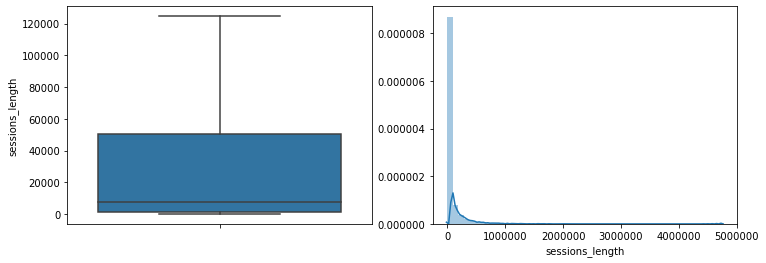

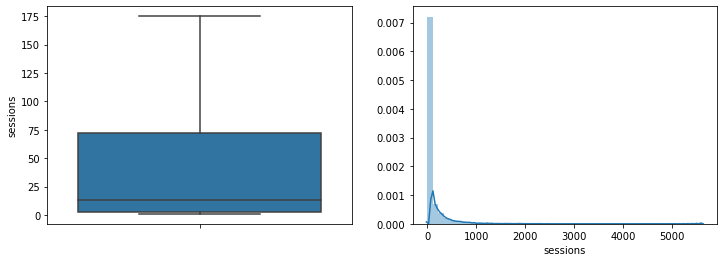

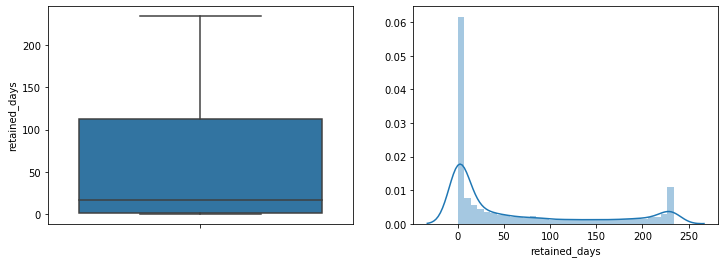

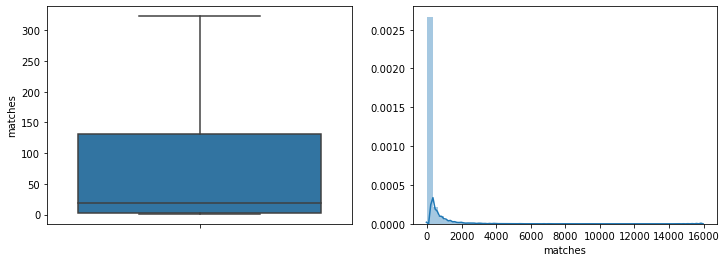

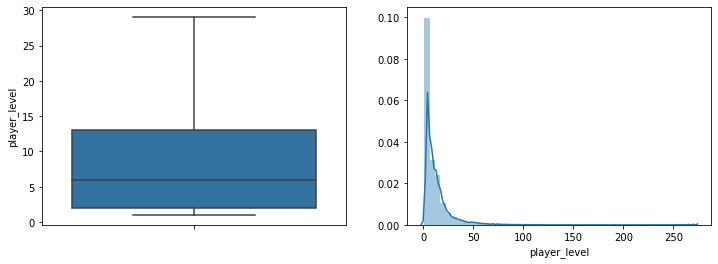

In [29]:
for col in ordinal:
    
    f, axs = plt.subplots(1,2, figsize=(12,4))

    # Add a graph in each part
    sns.boxplot(y = df_trainval[col], ax=axs[0], showfliers=False)
    sns.distplot(df_trainval[col], ax=axs[1])


## Nominal features

* The representativity of countries is highly unbalanced, with 1 country accounting for 24% of the players and multiple coutries having 1 or zero players (training set).
* One of the 3 possible platforms accounts for 67% of players.
* One of the 5 login_types accounts for 59% of players.

In [30]:
df_trainval[df_trainval.country==62]

,platform,country,sessions_length,sessions,retained_days,login_type,matches,player_level,is_payer


Text(0.5, 1.0, 'Top countries')

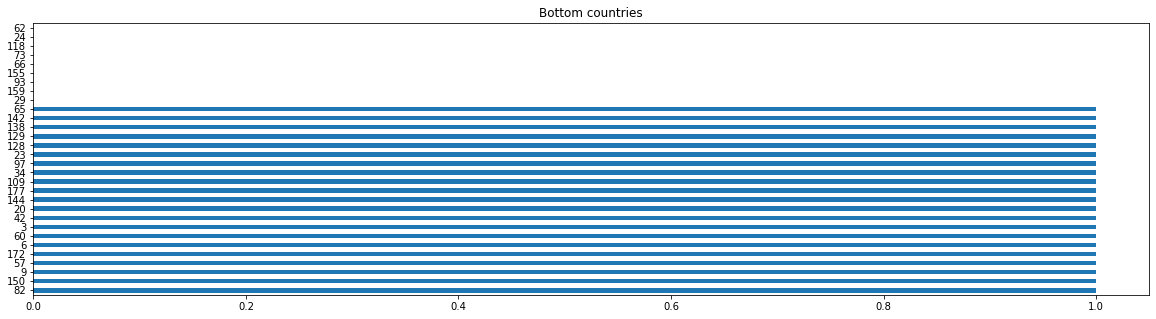

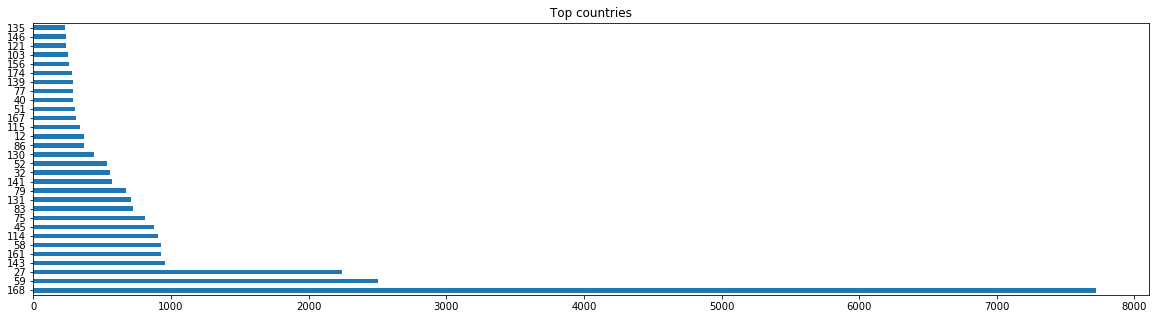

In [31]:
# Countries with zero counts appear because the field was converted to categorical, 
# so all categories are always present no matter what, and the counts of those countries eventually fell into the test set.
# This field will have to be converted back to numeric or the appearance of new countries in the data might cause errors.
country_counts = df_trainval.country.value_counts()
plt.figure();country_counts.tail(30).plot(kind='barh', figsize=(20,5)); plt.title('Bottom countries')
plt.figure();country_counts.head(30).plot(kind='barh', figsize=(20,5)); plt.title('Top countries')

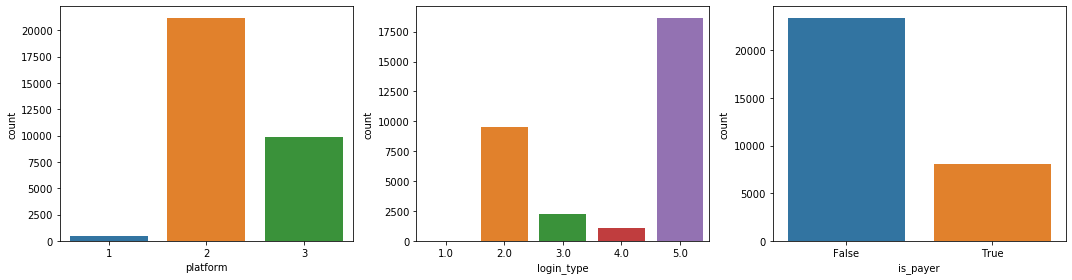

In [32]:
f, axs = plt.subplots(1,3,figsize=(15,4))

for idx, col in enumerate(['platform', 'login_type', 'is_payer']):    
    sns.countplot(df_trainval[col], ax=axs[idx])

plt.tight_layout()

In [34]:
pd.value_counts(df_trainval.platform, normalize=True)

2    0.673482
3    0.312613
1    0.013905
Name: platform, dtype: float64

In [35]:
pd.value_counts(df_trainval.login_type, normalize=True)

5.0    0.593066
2.0    0.301152
3.0    0.070891
4.0    0.034858
1.0    0.000032
Name: login_type, dtype: float64

In [33]:
pd.concat([pd.value_counts(df_trainval.is_payer, normalize=True),
           pd.value_counts(df_trainval.is_payer, normalize=False)], axis=1)

,is_payer,is_payer
False,0.744055,23437
True,0.255945,8062


In [36]:
# The top country amounts for about 25% of players
pd.concat([pd.value_counts(df_trainval.country, normalize=True).head(),
           pd.value_counts(df_trainval.country, normalize=False).head()], axis=1)

,country,country
168,0.245151,7722
59,0.079590,2507
27,0.071113,2240
143,0.030414,958
161,0.029556,931


# Multivariate analysis

* From the plot below, ordinal features seem to be positively correlated (more sessions -> more matches -> higher players level).
* Distributions of retained days and player level have a visible difference between paying and non-paying players.

Wall time: 19.8 s


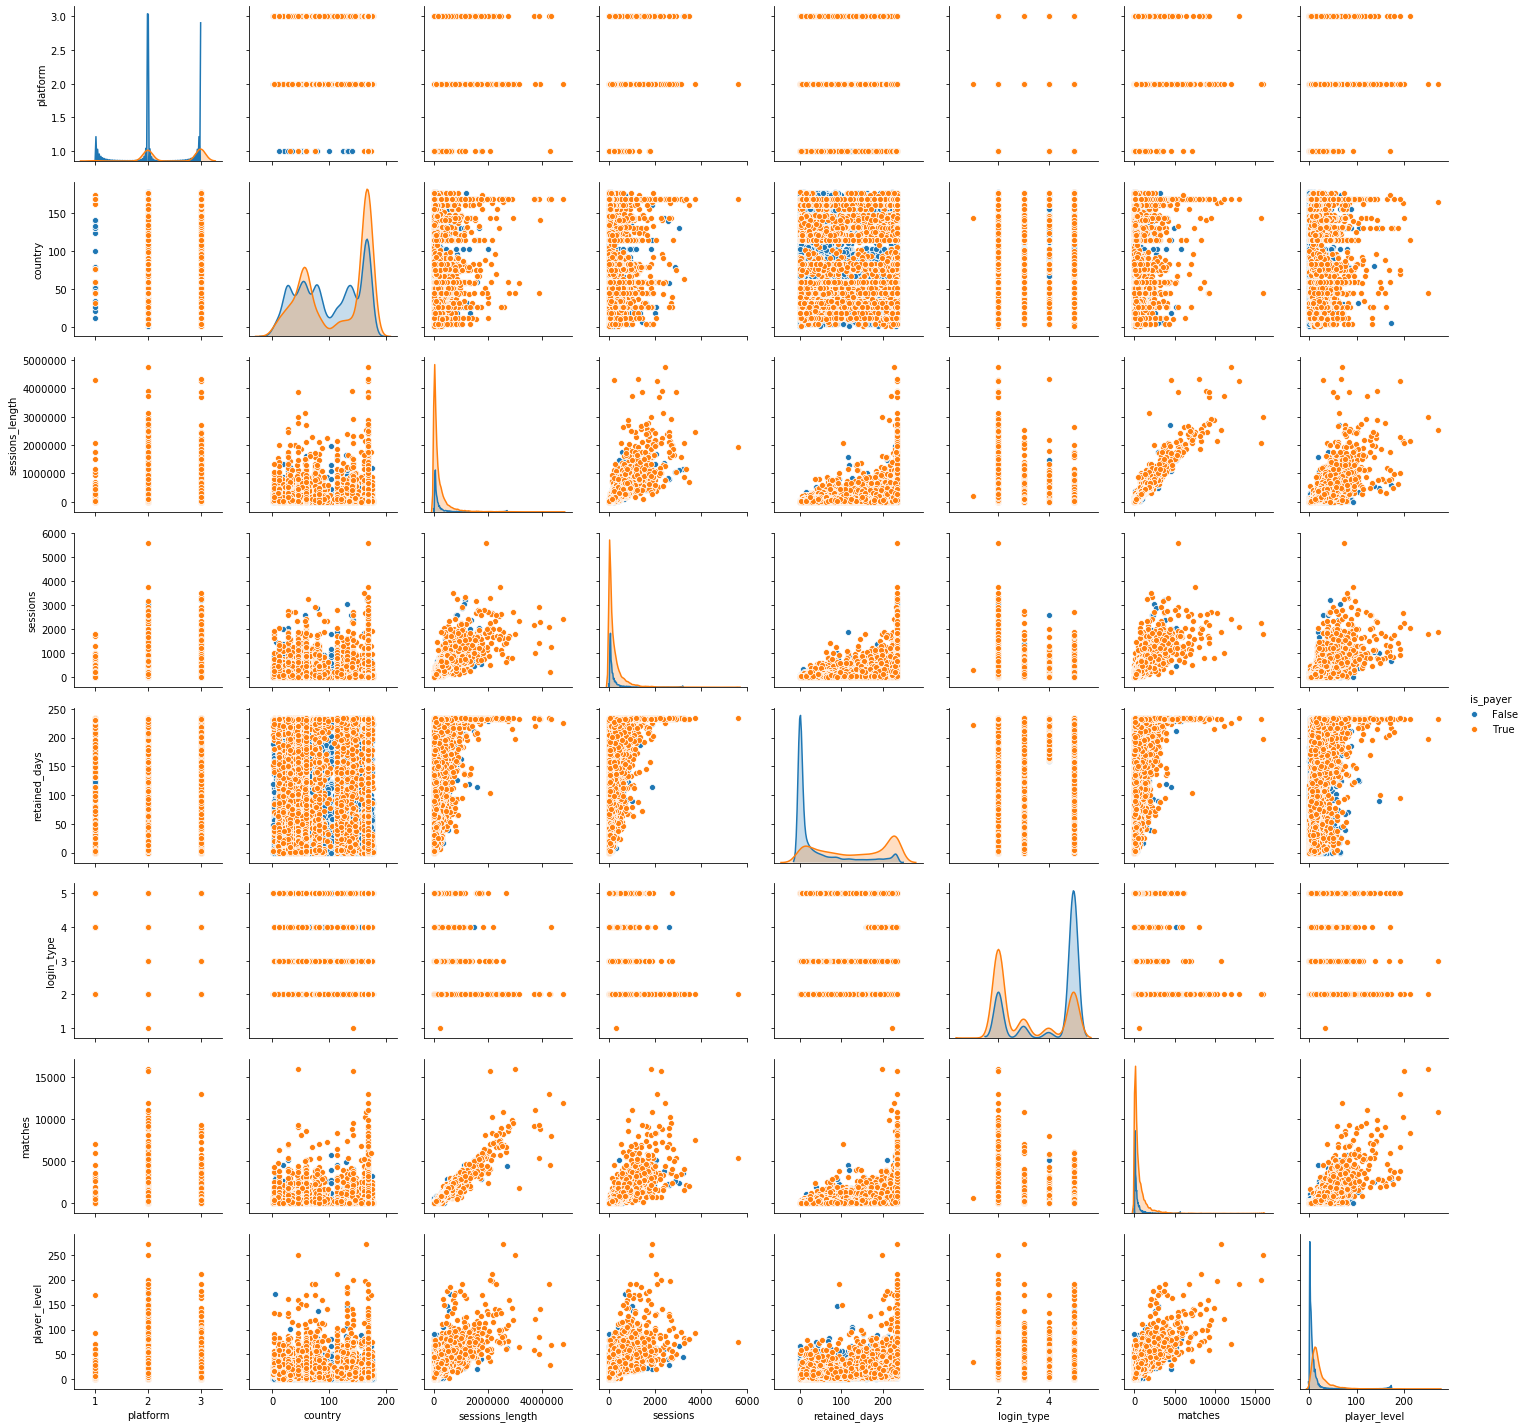

In [28]:
%%time
sns.pairplot(df_trainval, hue=target, 
             x_vars=df_trainval.drop(target, axis=1).columns,
             y_vars=df_trainval.drop(target, axis=1).columns)

## Cat vs Cat

* Even though most players use login_type = 5, most payers go for login_type = 2.
* Payers are nearly equally distributed between platforms 2 and 3, even though the full population tends more to platform 2.
* The country with most players is also that with more paying players.

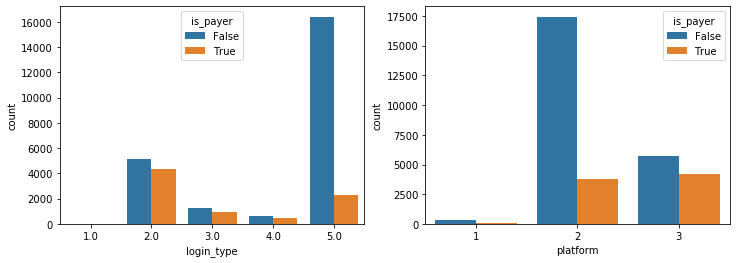

In [37]:
# login_type = 2 has the greater group of payers and these are almost as many as the non payers
# payers are nearly equally distributed between platforms 2 and 3. In 3 these are almost as many as the non-payers.
f, axs = plt.subplots(1,2,figsize=(12,4))

for idx, col in enumerate(['login_type', 'platform']):
    if (col != target) & (col != 'country'):
        sns.countplot(df_trainval[col], hue=df_trainval[target], ax=axs[idx])

In [38]:
# there is only one record for login_type = 1
# this happens to be a payer
df_trainval[df_trainval.login_type==1]

,platform,country,sessions_length,sessions,retained_days,login_type,matches,player_level,is_payer
2164,2,143,215712,312,222,1.0,627.0,34.0,True


In [39]:
df_trainval.sessions_length.max()

4748638

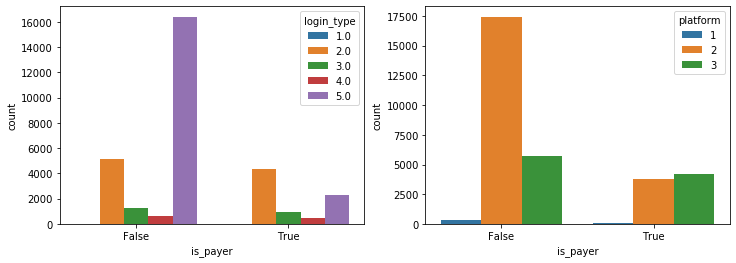

In [40]:
# login_type = 5 is the most common but not that conveying more payers
f, axs = plt.subplots(1,2,figsize=(12,4))

for idx, col in enumerate(['login_type', 'platform']):
    sns.countplot(df_trainval[target], hue=df_trainval[col], ax=axs[idx])

In [41]:
country_counts_hue = df_trainval.groupby(['country','is_payer'])['platform'].count().reset_index()

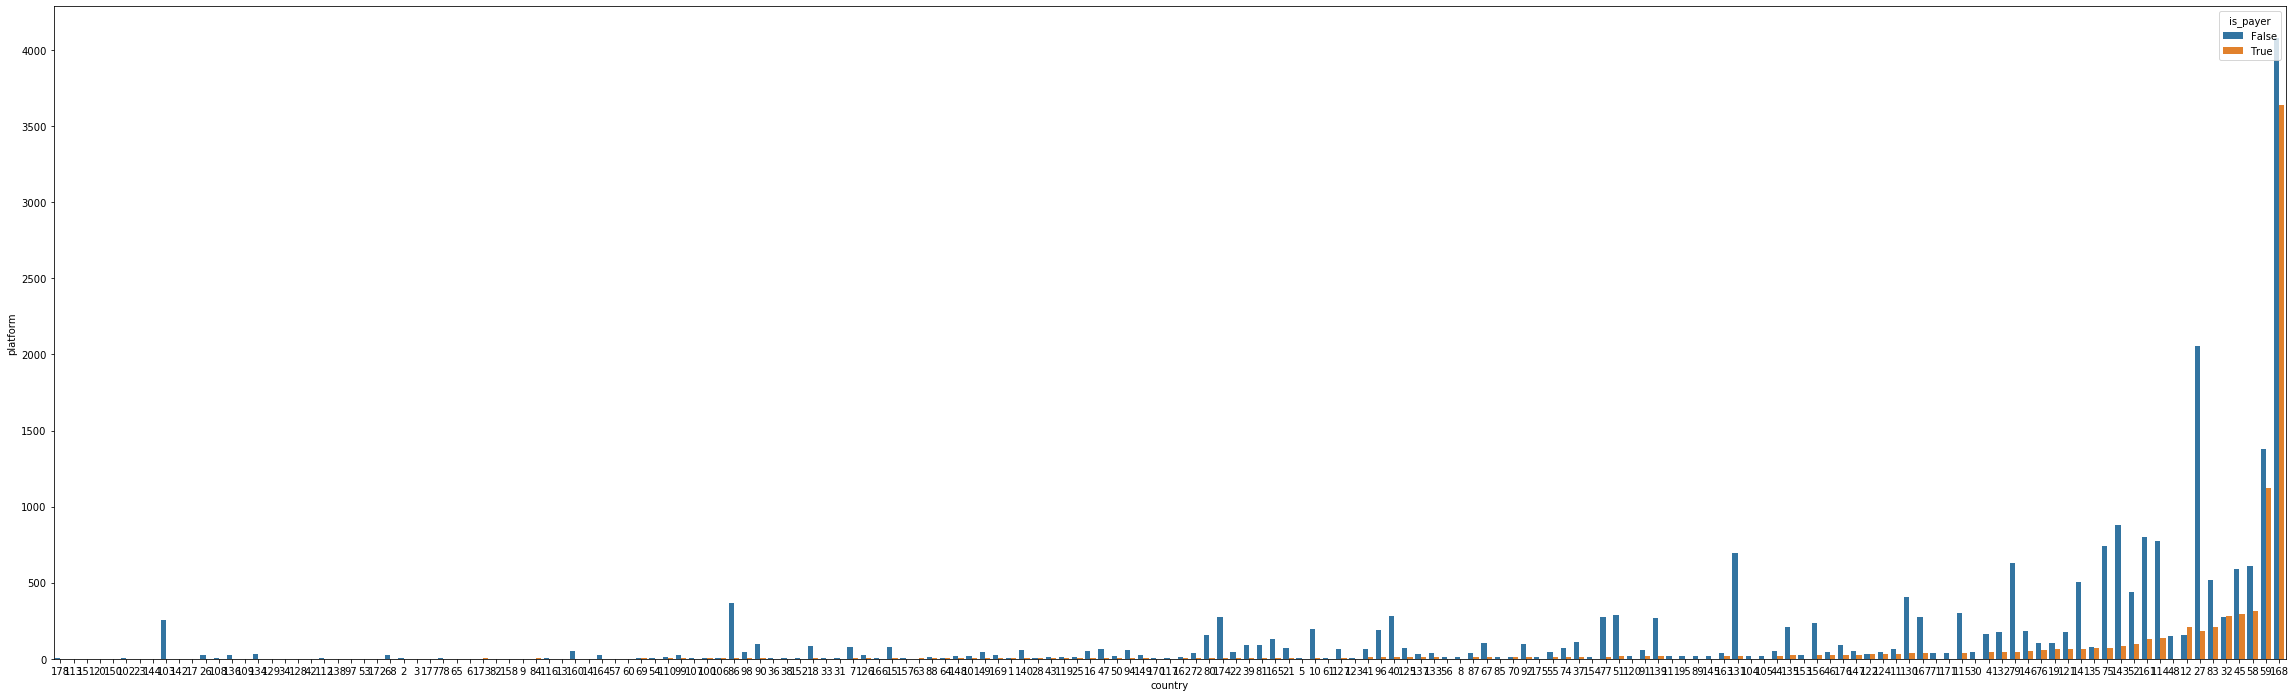

In [42]:
# country 168 has the greatest part of customers and a good proportion of payers
country_counts_hue = df_trainval.groupby(['country','is_payer'])['platform'].count().reset_index().sort_values(by='platform')

f,ax = plt.subplots(figsize=(40,12))
sns.barplot(x='country', y='platform', data=country_counts_hue, hue='is_payer', orient='v', order=country_counts_hue.country.unique())

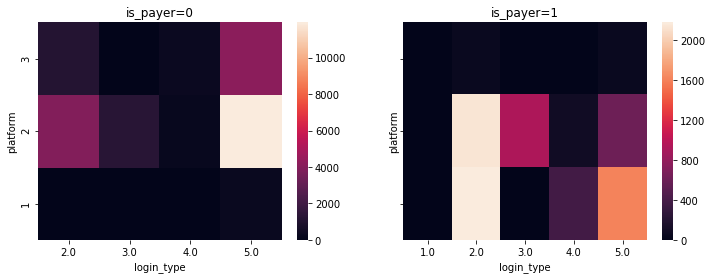

In [37]:
f, axs = plt.subplots(1,2,figsize=(12,4), sharey=True)

for i in [0,1]:
    sns.heatmap(pd.crosstab(df_trainval[df_trainval[target] == i].platform,
                            df_trainval[df_trainval[target] == i].login_type), ax=axs[i]); axs[i].set_title(target + '=' + str(i))

## Cat vs num

* The distributions of ordinal features for paying and non-paying players allow separating these 2 groups with a few false classifications. For example:
    + 80% of non-paying customers have a player_level below or equal to that of 80% of paying ones.
    + 75% of non-paying customers have as many or less matches than 85% of paying ones.
    
* For some countries, the difference in player_level of paying and non-paying players is even more precise.

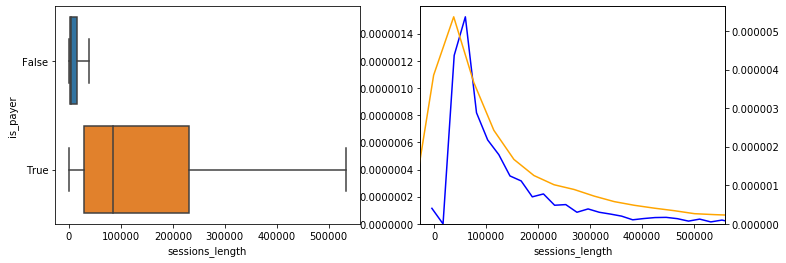

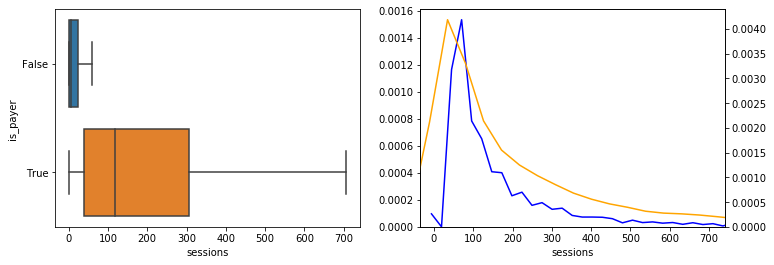

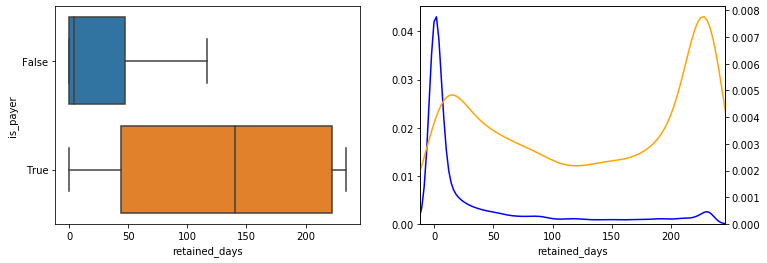

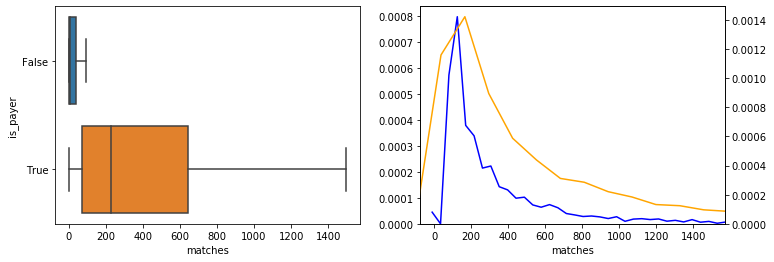

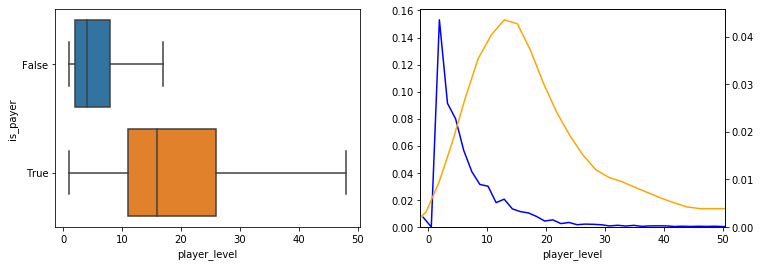

In [43]:
for col in ordinal:
    
    f, axs = plt.subplots(1,2, figsize=(12,4))

    # Add a graph in each part
    sns.boxplot(data = df_trainval, x=col, y=target, ax=axs[0], showfliers=False)
    sns.distplot(df_trainval[df_trainval[target]==0][col], ax=axs[1], color='blue', hist=False)
    sns.distplot(df_trainval[df_trainval[target]==1][col], ax=axs[1].twinx(), color='orange', hist=False)
    axs[1].set_xlim(axs[0].get_xlim()) # set the limits in the dist plots equal to those in the boxplots, hidding outliers


In [44]:
describes_0 = df_trainval[df_trainval.is_payer==0][ordinal].describe(percentiles=[0.5, 0.6, 0.75, 0.8, 0.85, 0.9])
describes_1 = df_trainval[df_trainval.is_payer==1][ordinal].describe(percentiles=[0.1, 0.15, 0.2, 0.25, 0.3, 0.5])

In [45]:
# 75% of non-paying customers have lower values in all ordinal features compared to 75% percentile of paying ones
# 80% of non-paying customers have a player_level below or equal that of 80% of paying ones
# 75% of non-paying customers have as many or less matches than 85% of paying ones
pd.concat([describes_0.loc['85%',:], describes_1.loc['30%',:]], axis=1)

,85%,30%
sessions_length,37351.8,36276.0
sessions,55.0,51.0
retained_days,108.0,59.0
matches,95.0,95.0
player_level,11.0,12.0


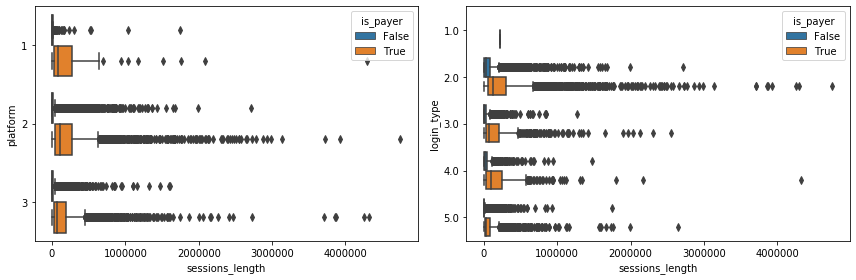

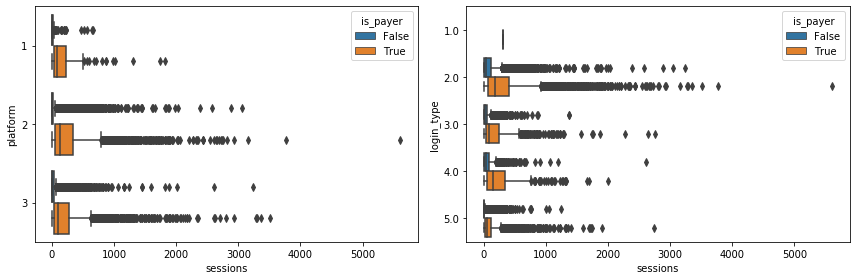

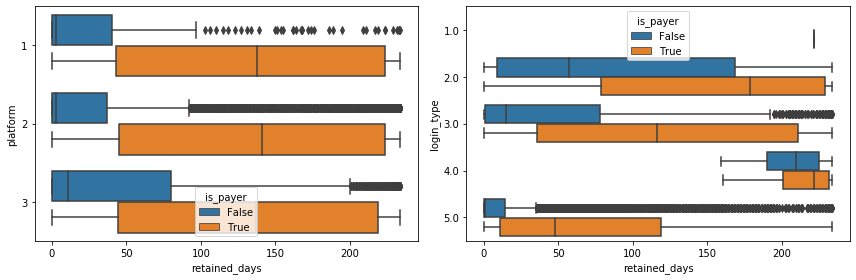

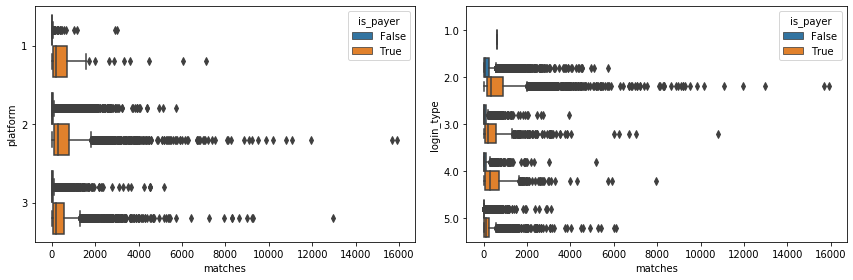

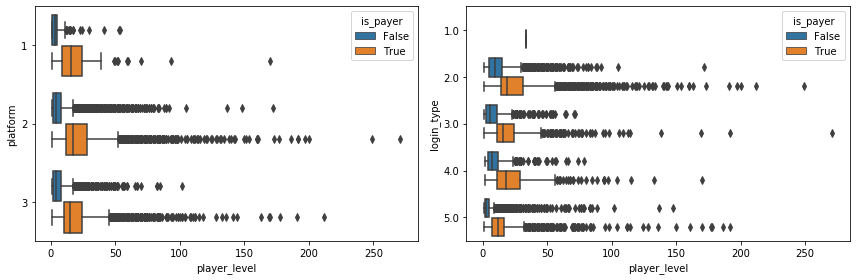

In [39]:
for col in ordinal:
    
    f, axs = plt.subplots(1,2, sharex=True, figsize=(12,4))

    # Add a graph in each part
    sns.boxplot(data=df_trainval, x=col, y='platform', hue='is_payer', ax=axs[0])
    sns.boxplot(data=df_trainval, x=col, y='login_type', hue='is_payer', ax=axs[1])
    plt.tight_layout()
    

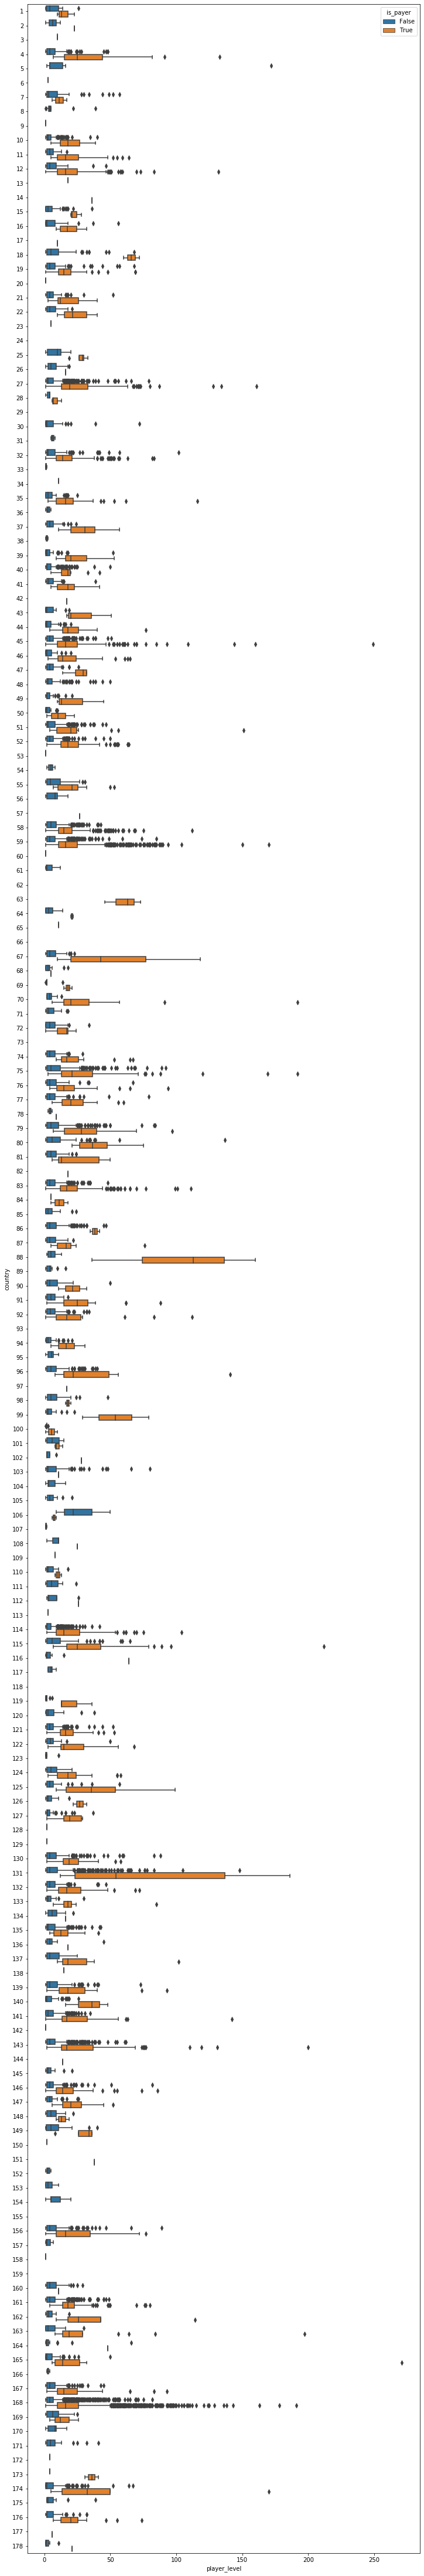

In [40]:
# for each individual country, paying customers typically have higher player_level than non-paying ones.
plt.figure(figsize=(12,80))
sns.boxplot(data=df_trainval, x='player_level', y='country', hue='is_payer')

## Num vs num

* All ordinal features exhibit positive correlation.
* Paying players have longer sessions and play more matches per day/session.
* The player level of non-paying players increases more with sessions and matches than that of paying players, but typically are not retained for as long. 

This may indicate that non-playing players invest in playing only while they can easily increase level but give up easily afterwards while paying players keep trying to improve. The difficulty in increasing player_level probably increases the higher the level is.

Wall time: 43.6 s


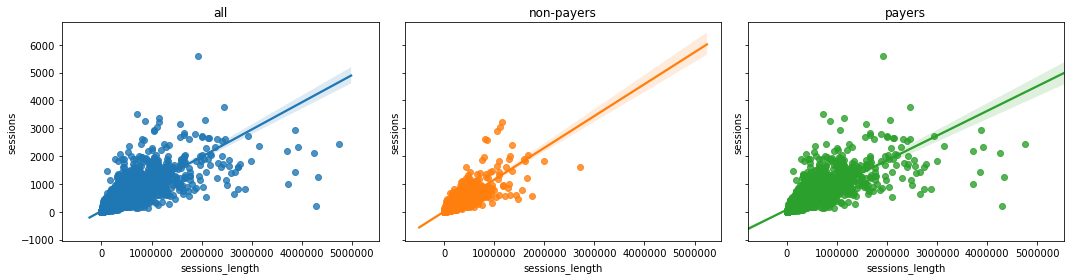

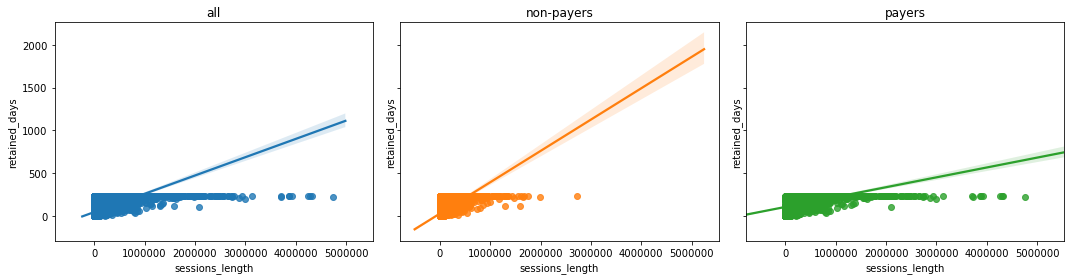

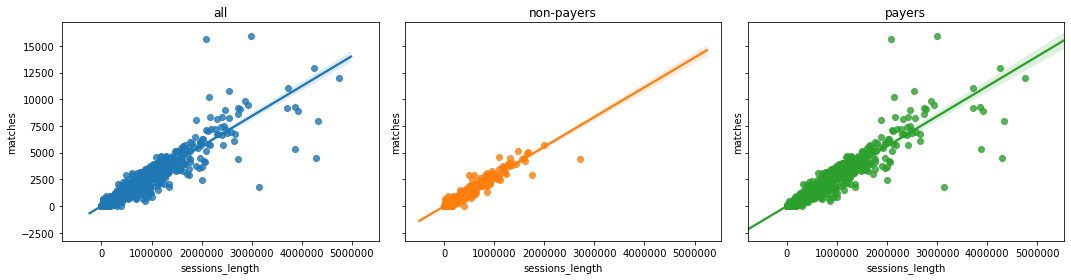

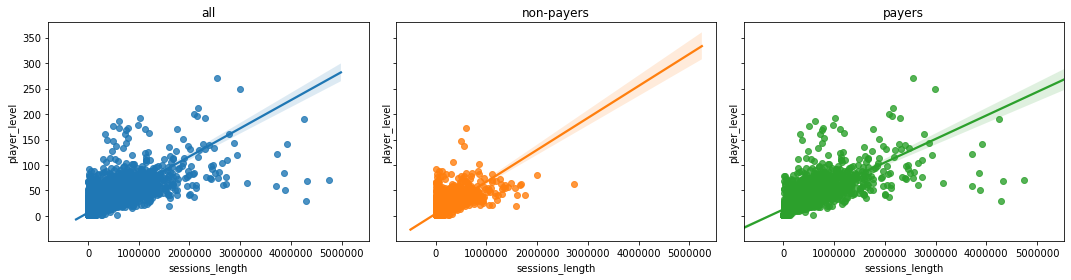

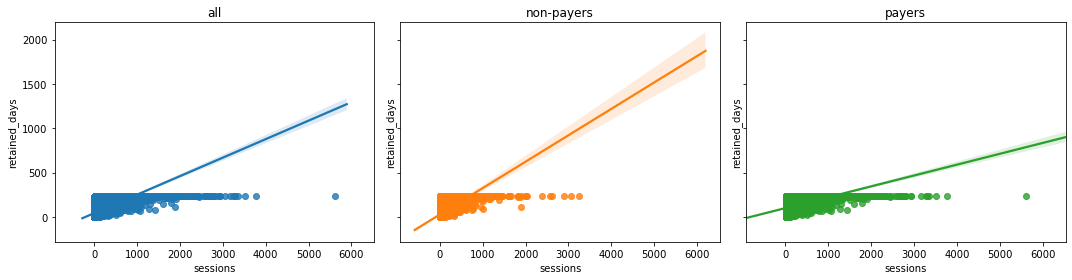

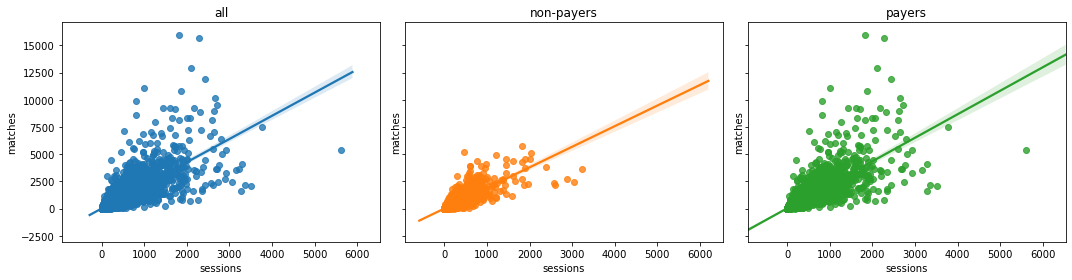

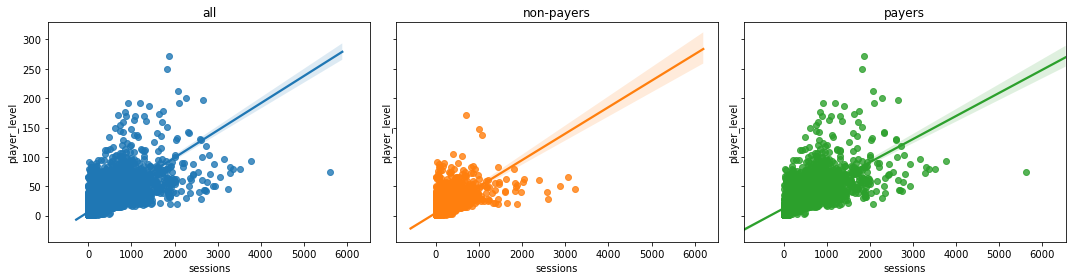

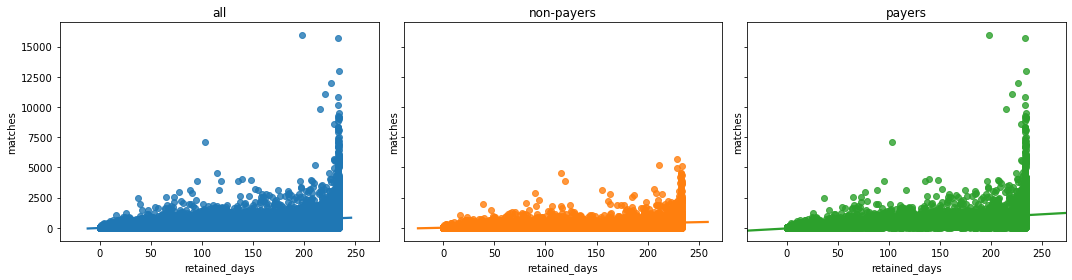

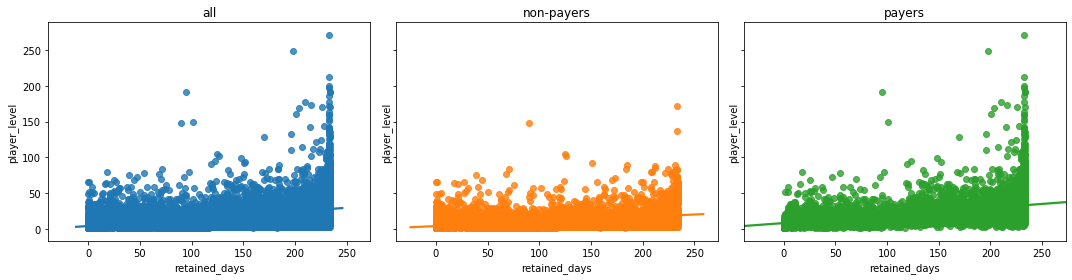

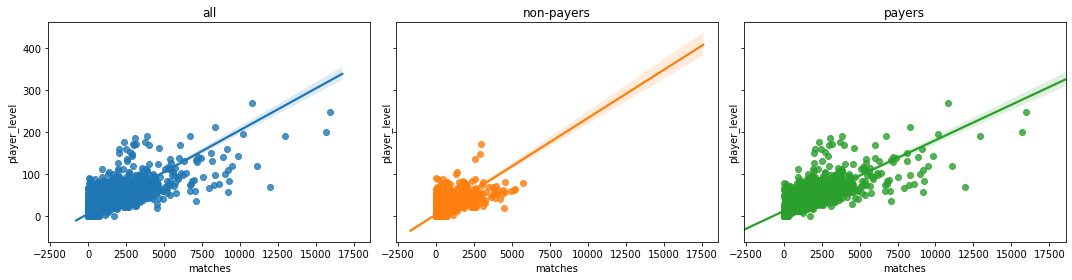

In [46]:
%%time
for x in np.arange(0,5):
    for y in np.arange(x+1,5):
        f, axs = plt.subplots(1,3,figsize=(15,4), sharey=True, sharex=True)
        sns.regplot(data=df_trainval, x=ordinal[x],y=ordinal[y], ax=axs[0]); axs[0].set_title('all')
        sns.regplot(data=df_trainval[df_trainval.is_payer==0], x=ordinal[x],y=ordinal[y], ax=axs[1]); axs[1].set_title('non-payers')
        sns.regplot(data=df_trainval[df_trainval.is_payer==1], x=ordinal[x],y=ordinal[y], ax=axs[2]); axs[2].set_title('payers')
        plt.tight_layout()

# Predictive model based on player_level

* A simple model can be built by taking the player_level as a proxy for the probability that the player will be paying.
    + 87% precision on the 100th percentile (77% on the 10th decile) - training set.
    + 91% precision on the 100th percentile (80% on the 10th decile) - test set.

In [48]:
rule_based = pd.DataFrame(columns=['tp', 'fp', 'fn', 'tn', 'recall', 'precision'], dtype='float64')

for level in np.arange(df_trainval.player_level.min(), df_trainval.player_level.max()+1):
    tp = len(df_trainval[(df_trainval.player_level >= level) & (df_trainval.is_payer == 1)])
    fp = len(df_trainval[(df_trainval.player_level >= level) & (df_trainval.is_payer == 0)])
    fn = len(df_trainval[(df_trainval.player_level <  level) & (df_trainval.is_payer == 1)])
    tn = len(df_trainval[(df_trainval.player_level <  level) & (df_trainval.is_payer == 0)])
    aux = pd.DataFrame({'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn, 'recall': tp/(tp+fn), 'precision': tp/(tp+fp)}, index=[int(level)])
    rule_based = rule_based.append(aux)

In [49]:
rule_based.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 1 to 271
Data columns (total 6 columns):
tp           271 non-null float64
fp           271 non-null float64
fn           271 non-null float64
tn           271 non-null float64
recall       271 non-null float64
precision    271 non-null float64
dtypes: float64(6)
memory usage: 14.8 KB


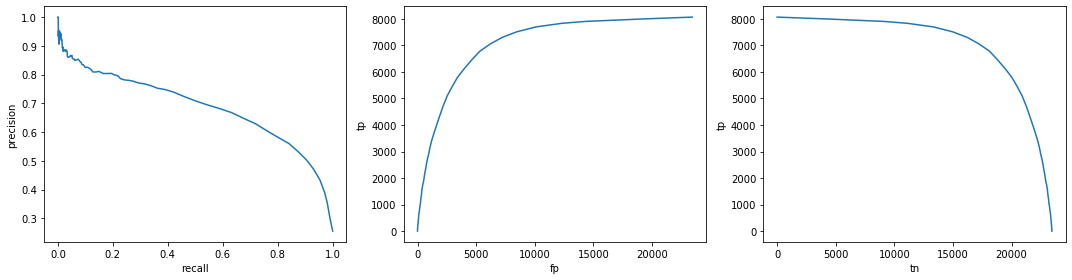

In [50]:
f, axs = plt.subplots(1,3,figsize=(15,4))

sns.lineplot(x=rule_based.recall, y=rule_based.precision, ax=axs[0])
sns.lineplot(x=rule_based.fp, y=rule_based.tp, ax=axs[1])
sns.lineplot(x=rule_based.tn, y=rule_based.tp, ax=axs[2])

plt.tight_layout()

In [51]:
percentiles = index_for_percentiles(array_length = len(df_trainval), num_splits = 100)
deciles     = index_for_percentiles(array_length = len(df_trainval), num_splits = 10)

In [69]:
percentile_metrics = quantile_metrics(df_trainval['is_payer'].astype(int), df_trainval['player_level']/np.max(df_trainval['player_level']), percentiles)
decile_metrics     = quantile_metrics(df_trainval['is_payer'].astype(int), df_trainval['player_level']/np.max(df_trainval['player_level']), deciles)

In [53]:
test_percentiles = index_for_percentiles(array_length = len(df_test), num_splits = 100)
test_deciles     = index_for_percentiles(array_length = len(df_test), num_splits = 10)

In [58]:
len(percentiles)

31499

In [71]:
test_percentile_metrics = quantile_metrics(df_test['is_payer'].astype(int), df_test['player_level']/np.max(df_test['player_level']), test_percentiles)
test_decile_metrics     = quantile_metrics(df_test['is_payer'].astype(int), df_test['player_level']/np.max(df_test['player_level']), test_deciles)

In [74]:
test_percentile_metrics.tail(3)

,n,tp,lift,precision,max_lift
quantile,,,,,
98.0,35,32,3.571429,0.914286,3.90625
99.0,35,31,3.459821,0.885714,3.90625
100.0,35,32,3.571429,0.914286,3.90625


In [75]:
percentile_metrics.tail(3)

,n,tp,lift,precision,max_lift
quantile,,,,,
98.0,315,246,3.051352,0.780952,3.907219
99.0,315,262,3.249814,0.831746,3.907219
100.0,315,275,3.411064,0.873016,3.907219


Text(0.5, 1.0, 'Test set')

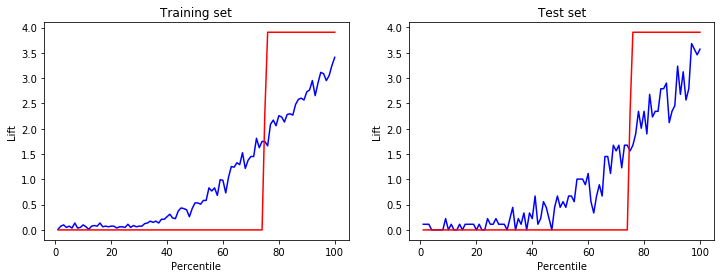

In [76]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(percentile_metrics['lift'], color='blue'); 
axs[0].plot(percentile_metrics['max_lift'], color='red'); 
axs[0].set_xlabel('Percentile'); axs[0].set_ylabel('Lift'); axs[0].set_title('Training set')

axs[1].plot(test_percentile_metrics['lift'], color='blue'); 
axs[1].plot(test_percentile_metrics['max_lift'], color='red'); axs[1].set_xlabel('Percentile'); axs[1].set_ylabel('Lift'); axs[1].set_title('Test set')

In [77]:
compare_model_quantile_metrics([percentile_metrics, test_percentile_metrics], ['Training set','Test set'], 2)

,quantile,n,tp,lift,precision,max_lift
Training set,99.0,315,262,3.249814,0.831746,3.907219
Training set,100.0,315,275,3.411064,0.873016,3.907219
Test set,99.0,35,31,3.459821,0.885714,3.906250
Test set,100.0,35,32,3.571429,0.914286,3.906250


In [78]:
compare_model_quantile_metrics([decile_metrics, test_decile_metrics], ['Training set','Test set'], 2)

,quantile,n,tp,lift,precision,max_lift
Training set,9.0,3150,1949,2.417514,0.618730,3.907219
Training set,10.0,3150,2430,3.014140,0.771429,3.907219
Test set,9.0,350,219,2.444196,0.625714,3.906250
Test set,10.0,350,279,3.113839,0.797143,3.906250
